# A general model to calculate the spin-lattice relaxation rate (R1) of blood, accounting for haematocrit, oxygen saturation, oxygen partial pressure, and magnetic field strength under hyperoxic conditions

Emma Bluemke, Eleanor Stride, Daniel Bulte

Institute of Biomedical Engineering, Department of Engineering Sciences, University of Oxford, UK

Questions? Raise an issue here on GitHub

## Abstract

Under normal physiological conditions, the R1 in blood is influenced by many factors, including haematocrit, field strength, temperature, protein concentrations, and the weak paramagnetic effects of deoxyhaemoglobin and dissolved oxygen. In addition, techniques such as oxygen-enhanced MRI require high fractions of inspired oxygen to induce hyperoxia, which complicates the R1 signal further. Whilst a linear increase in R1 with oxygen partial pressure has been reported in phantoms, measurements in blood have produced contradictory effects. A quantitative model relating total blood oxygen content to R1 could help explain these contradictory effects. 
 
Existing models for blood R1 can account for SO2, haematocrit, and magnetic field strength (B0), but are not applicable under conditions of artificially increased PO2, or hyperoxic experiments. Therefore, we present a general model to estimate the R1 of blood, accounting for haematocrit, SO2, PO2, and B0 under both normal physiological and normobaric hyperoxic conditions.

As a future direction of this work, we have hosted the open-source model code and a current list of blood R1 measurements on GitHub and invite the MRI community to share new blood R1 measurement results and refit the model to improve accuracy. Such a project would greatly improve this model as T1, Hct, SO2 and PO2 measurement methods continue to improve in accuracy over the years to come. 

## Imports

In [1]:
import numpy as np
import math
import random
from scipy.optimize import least_squares
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
plt.style.use('seaborn-white')
from sklearn.model_selection import train_test_split
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from sklearn.metrics import mean_squared_error
from RegscorePy import *

## Visually check if your data table loaded in correctly (i.e. no blank rows on the bottom)

In [2]:
r1data = pd.read_csv('R1blood_data_table.csv')
r1data

,Ref,B0,R1,Hct,fwatere,so2,po2,P50,Refnumber,Unnamed: 9
0,Stefanovic and Pike,1.5,0.830475,0.512,0.450025,0.42,22.183086,25,1,NaN
1,Stefanovic and Pike,1.5,0.808257,0.512,0.450025,0.43,22.521863,25,1,NaN
2,Stefanovic and Pike,1.5,0.797822,0.512,0.450025,0.48,24.269742,25,1,NaN
3,Stefanovic and Pike,1.5,0.795465,0.512,0.450025,0.62,29.969793,25,1,NaN
4,Stefanovic and Pike,1.5,0.793109,0.512,0.450025,0.66,31.961765,25,1,NaN
...,...,...,...,...,...,...,...,...,...,...
121,Lu et al,3.0,0.633000,0.460,0.396552,0.97,159.434566,44,10,NaN
122,Lu et al,3.0,0.599000,0.380,0.318182,0.64,54.450251,44,10,NaN
123,Lu et al,3.0,0.617000,0.400,0.337349,0.64,54.450251,44,10,NaN
124,Lu et al,3.0,0.627000,0.420,0.356796,0.64,54.450251,44,10,NaN


## Quick data visualization: sorted by author

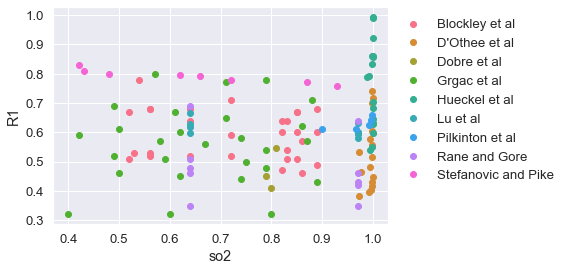

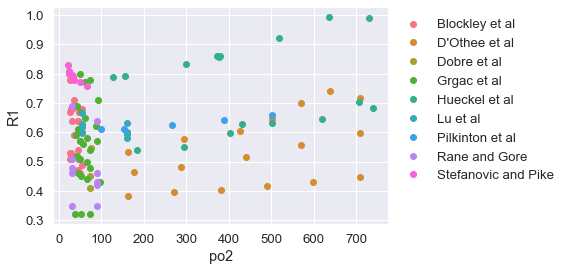

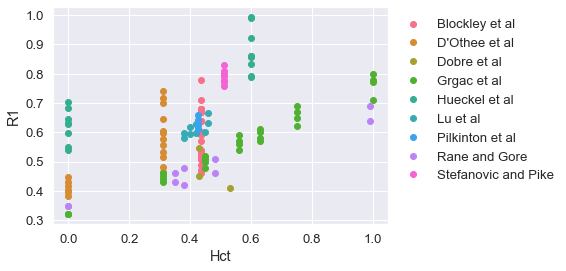

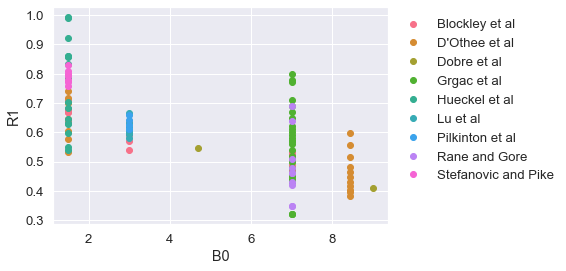

In [3]:
sns.set(font_scale=1.2)
sns.set_palette("husl", 9)
groups = r1data.groupby('Ref')
# Plot

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.so2, group.R1, marker='o', linestyle='', label=name)
ax.legend(bbox_to_anchor=(1, 1))
plt.xlabel('so2')
plt.ylabel('R1')
plt.show()

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.po2, group.R1, marker='o', linestyle='', label=name)
ax.legend(bbox_to_anchor=(1, 1))
plt.xlabel('po2')
plt.ylabel('R1')
plt.show()

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.Hct, group.R1, marker='o', linestyle='', label=name)
ax.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Hct')
plt.ylabel('R1')
plt.show()

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.B0, group.R1, marker='o', linestyle='', label=name)
ax.legend(bbox_to_anchor=(1, 1))
plt.xlabel('B0')
plt.ylabel('R1')
plt.show()

## Quick data visualization: sorted by variable

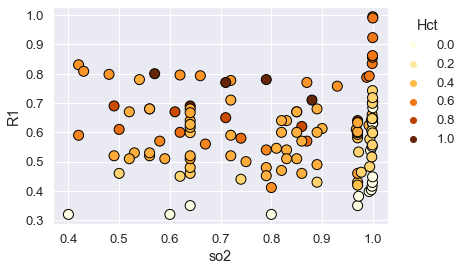

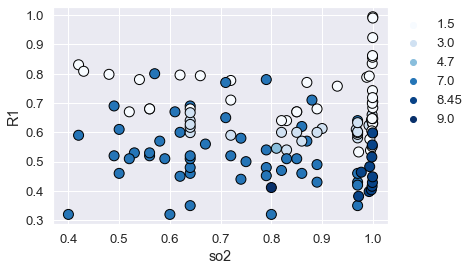

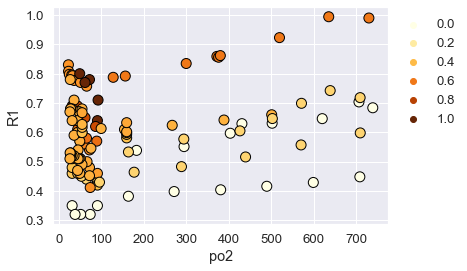

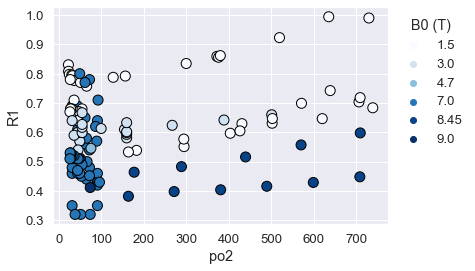

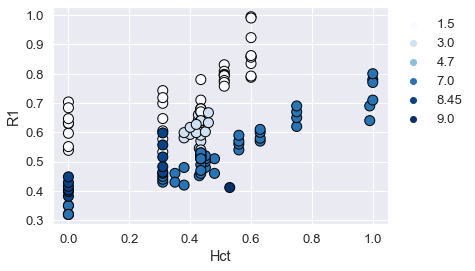

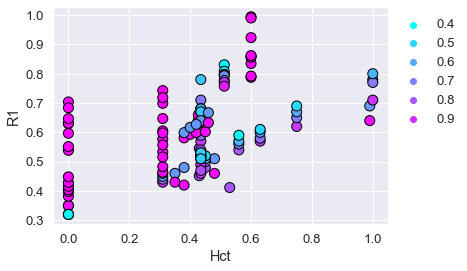

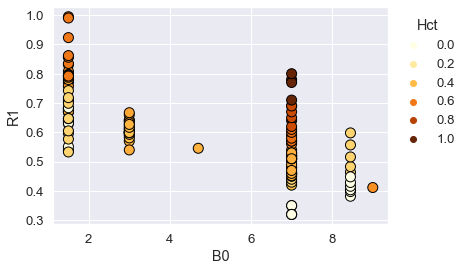

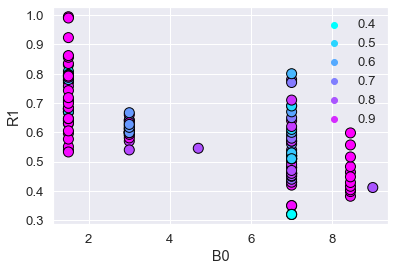

In [4]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
sns.scatterplot(x="so2", y="R1", data=r1data, hue="Hct",palette="YlOrBr",edgecolor='black',linewidth=1,s=100)
ax.legend(bbox_to_anchor=(1, 1),title='Hct')

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
sns.scatterplot(x="so2", y="R1", data=r1data, hue="B0",palette="Blues",edgecolor='black',linewidth=1,s=100)
ax.legend(bbox_to_anchor=(1, 1))


fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
sns.scatterplot(x="po2", y="R1", data=r1data, hue="Hct",palette="YlOrBr",edgecolor='black',linewidth=1,s=100)
ax.legend(bbox_to_anchor=(1, 1))


fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
sns.scatterplot(x="po2", y="R1", data=r1data, hue="B0",palette="Blues",edgecolor='black',linewidth=1,s=100)
ax.legend(bbox_to_anchor=(1, 1),title='B0 (T)')


fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

sns.scatterplot(x="Hct", y="R1", data=r1data, hue="B0",palette="Blues",edgecolor='black',linewidth=1,s=100)
ax.legend(bbox_to_anchor=(1, 1))

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
sns.scatterplot(x="Hct", y="R1", data=r1data, hue="so2",palette="cool",edgecolor='black',linewidth=1,s=100)
ax.legend(bbox_to_anchor=(1, 1))


fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
sns.scatterplot(x="B0", y="R1", data=r1data, hue="Hct",palette="YlOrBr",edgecolor='black',linewidth=1,s=100)
ax.legend(bbox_to_anchor=(1, 1),title='Hct')


fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
sns.scatterplot(x="B0", y="R1", data=r1data, hue="so2",palette="cool",edgecolor='black',linewidth=1,s=100)
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## Model fitting 
Tip: You can reduce nrepetitions to 100 for faster debugging and testing.

In [5]:
r1data = pd.read_csv('R1blood_data_table.csv')
r1data

nrepetitions=10000
nsamples=math.floor(len(r1data)*0.95)
ntest=len(r1data)-nsamples

list_of_bR1eox=np.zeros(nrepetitions)
list_of_mR1eox=np.zeros(nrepetitions)
list_of_mr1deoxyHb=np.zeros(nrepetitions)
list_of_br1deoxyHb=np.zeros(nrepetitions)
list_of_bR1p=np.zeros(nrepetitions)
list_of_br1pox_r1=np.zeros(nrepetitions)
list_of_mr1pox_r1=np.zeros(nrepetitions)

list_of_y_guess=np.zeros((nrepetitions,ntest))
list_of_y_test=np.zeros((nrepetitions,ntest))
list_of_B0_test=np.zeros((nrepetitions,ntest))
list_of_po2_test=np.zeros((nrepetitions,ntest))
list_of_fw_test=np.zeros((nrepetitions,ntest))
list_of_Hct_test=np.zeros((nrepetitions,ntest))
list_of_P50_test=np.zeros((nrepetitions,ntest))
list_of_refs_test=np.zeros((nrepetitions,ntest))

B0_alldata=r1data.B0
y_alldata=r1data.R1
fw_alldata=r1data.fwatere
po2_alldata=r1data.po2
Hct_alldata=r1data.Hct
P50_alldata=r1data.P50
refnumber=r1data.Refnumber



n=2.7

Hb=5.15



for i in range(0,nrepetitions):
    
    P50,P50_test,B0,B0_test,y,y_test,fw,fw_test,po2,po2_test,Hct,Hct_test = train_test_split(P50_alldata,B0_alldata,y_alldata,fw_alldata,po2_alldata,Hct_alldata, test_size=0.05)


    def R1funB0_5(x, fw, y, po2,B0,P50):

        return fw*((x[0]+(x[1]*B0))+((x[2]+(x[3]*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n))))))+(1-fw)*(x[4]+((x[5]+(x[6]*B0))*po2))-y

    x0_5 = np.array([1.0,-1,1.0,-1.0,1.0,1.0,-1.0])
    res_lsq_5 = least_squares(R1funB0_5, x0_5, args=(fw,y,po2,B0,P50))

    y_guess=fw_test*((res_lsq_5.x[0]+(res_lsq_5.x[1]*B0_test)) + ((res_lsq_5.x[2]+(res_lsq_5.x[3]*B0_test))*Hb*(1-((po2_test**n)/((po2_test**n)+(P50_test**n)))))) + (1-fw_test)*(res_lsq_5.x[4]+((res_lsq_5.x[5]+(res_lsq_5.x[6]*B0_test))*po2_test))


    
    list_of_y_test[i]=y_test
    list_of_y_guess[i]=y_guess
    list_of_B0_test[i]=B0_test
    list_of_fw_test[i]=fw_test
    list_of_po2_test[i]=po2_test
    list_of_Hct_test[i]=Hct_test
    list_of_P50_test[i]=P50_test


    
    list_of_bR1eox[i] =res_lsq_5.x[0]
    list_of_mR1eox[i] =res_lsq_5.x[1]
    list_of_br1deoxyHb[i] =res_lsq_5.x[2]
    list_of_mr1deoxyHb[i] =res_lsq_5.x[3]
    list_of_bR1p[i] =res_lsq_5.x[4]
   
    list_of_br1pox_r1[i] =res_lsq_5.x[5]
    list_of_mr1pox_r1[i] =res_lsq_5.x[6]
    

## Density scatter plots of the modelled vs measured R1blood values
The modelled vs measured R1blood values from the randomized unseen test set of each iteration, plotted against the line of equality (solid black line) and a linear regression (dotted line). The scatterplot points are coloured by density (bright=more dense). (B) A Bland-Altman plots showing the difference between the modelled and measured values of R1b from the randomized unseen test set of each iteration. The horizontal long-dashed line show the mean value of ΔR1blood, and the horizontal dotted lines show the limits of agreement (long dashes, calculated by mean(ΔR1b) ± (1.96xSD(ΔR1b)). The Bland-Altman plots for the error in modelled R1b against (C) SO2, (D) hematocrit, (E) field strength, and (F) PO2 levels are also shown to examine bias in the model.

### This will give you the MSE and R2

In [67]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
    z[np.where(np.isnan(z))] = 0.0
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    ax.scatter( x, y, c=z, **kwargs )
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    return ax


flat_list_of_y_test=list_of_y_test.flatten()
flat_list_of_y_guess=list_of_y_guess.flatten()
flat_list_of_B0_test=list_of_B0_test.flatten()
flat_list_of_po2_test=list_of_po2_test.flatten()
flat_list_of_fw_test=list_of_fw_test.flatten()
flat_list_of_Hct_test=list_of_Hct_test.flatten()
flat_list_of_P50_test=list_of_P50_test.flatten()

y_error=flat_list_of_y_guess-flat_list_of_y_test
mean_R1error=np.mean(y_error)
std_R1error=np.std(y_error)

y_guess_reshape=np.reshape(flat_list_of_y_guess,(-1, 1))
y_test_reshape=np.reshape(flat_list_of_y_test,(-1, 1))

reg_v_true = LinearRegression().fit(y_test_reshape, y_guess_reshape)

meanSE=mean_squared_error(y_test_reshape, y_guess_reshape)


print('MSE=',meanSE)
print('Estimate vs True R2=',reg_v_true.score(y_test_reshape, y_guess_reshape))
print('meanerror',mean_R1error)

MSE= 0.0015642753821967737
Estimate vs True R2= 0.9176114912965289
meanerror 0.00011890071693861005


### This will produce the density plots of Predicted vs True and Bland-Altman plots 

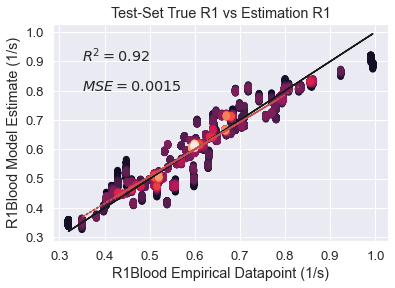

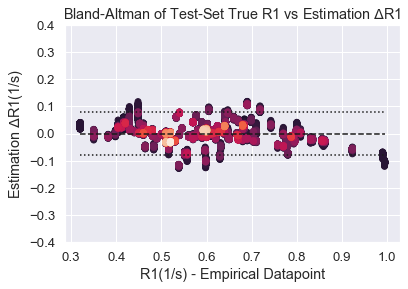

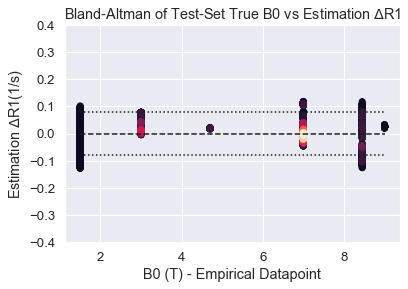

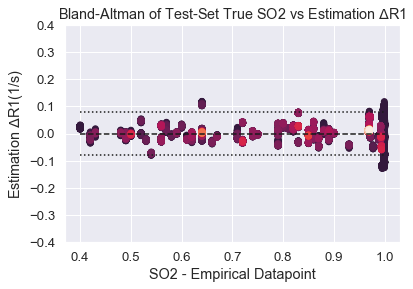

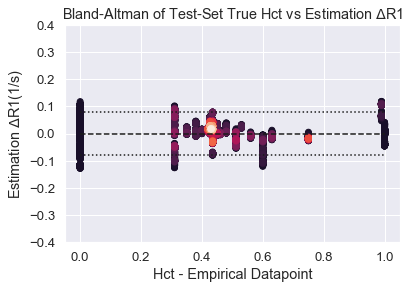

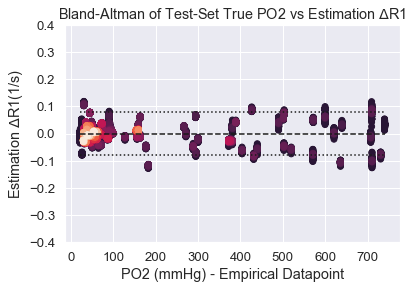

In [66]:
sns.set(font_scale=1.2)
density_scatter(flat_list_of_y_test, flat_list_of_y_guess, bins = [50,50] )
plt.plot(flat_list_of_y_test,flat_list_of_y_test,'k')
plt.plot(y_test_reshape,np.squeeze(reg_v_true.predict(y_test_reshape)),'r',linestyle='dotted')
plt.text(0.35,0.9, '$R^2=0.92$')
plt.text(0.35,0.8, '$MSE=0.0015$')
plt.xlabel('R1Blood Empirical Datapoint (1/s)')
plt.ylabel('R1Blood Model Estimate (1/s)')
plt.title('Test-Set True R1 vs Estimation R1')

crude_lower_limit = mean_R1error-1.96*std_R1error
crude_upper_limit = mean_R1error+ 1.96*std_R1error

density_scatter(flat_list_of_y_test,y_error,bins = [50,50])
plt.hlines(mean_R1error,np.min(list_of_y_test),np.max(list_of_y_test),linestyle='dashed')
plt.hlines(crude_lower_limit,np.min(list_of_y_test),np.max(list_of_y_test),linestyle='dotted')
plt.hlines(crude_upper_limit,np.min(list_of_y_test),np.max(list_of_y_test),linestyle='dotted')
plt.ylim(-0.4,0.4)
plt.xlabel('R1(1/s) - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$R1(1/s)')
plt.title('Bland-Altman of Test-Set True R1 vs Estimation $\Delta$R1')
plt.show()


density_scatter(flat_list_of_B0_test,y_error,bins = [50,50])
plt.hlines(mean_R1error,np.min(flat_list_of_B0_test),np.max(flat_list_of_B0_test),linestyle='dashed')
plt.hlines(crude_lower_limit,np.min(flat_list_of_B0_test),np.max(flat_list_of_B0_test),linestyle='dotted')
plt.hlines(crude_upper_limit,np.min(flat_list_of_B0_test),np.max(flat_list_of_B0_test),linestyle='dotted')
plt.ylim(-0.4,0.4)
plt.xlabel('B0 (T) - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$R1(1/s)')
plt.title('Bland-Altman of Test-Set True B0 vs Estimation $\Delta$R1')
plt.show()

so2_test=(flat_list_of_po2_test**n)/((flat_list_of_po2_test**n)+(flat_list_of_P50_test**n))

density_scatter(so2_test,y_error,bins = [50,50])
plt.hlines(mean_R1error,np.min(so2_test),np.max(so2_test),linestyle='dashed')
plt.hlines(crude_lower_limit,np.min(so2_test),np.max(so2_test),linestyle='dotted')
plt.hlines(crude_upper_limit,np.min(so2_test),np.max(so2_test),linestyle='dotted')
plt.ylim(-0.4,0.4)
plt.xlabel('SO2 - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$R1(1/s)')
plt.title('Bland-Altman of Test-Set True SO2 vs Estimation $\Delta$R1')
plt.show()

density_scatter(flat_list_of_Hct_test,y_error,bins = [50,50])
plt.hlines(mean_R1error,np.min(flat_list_of_Hct_test),np.max(flat_list_of_Hct_test),linestyle='dashed')
plt.hlines(crude_lower_limit,np.min(flat_list_of_Hct_test),np.max(flat_list_of_Hct_test),linestyle='dotted')
plt.hlines(crude_upper_limit,np.min(flat_list_of_Hct_test),np.max(flat_list_of_Hct_test),linestyle='dotted')
plt.ylim(-0.4,0.4)
plt.xlabel('Hct - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$R1(1/s)')
plt.title('Bland-Altman of Test-Set True Hct vs Estimation $\Delta$R1')
plt.show()

density_scatter(flat_list_of_po2_test,y_error,bins = [50,50])
plt.hlines(mean_R1error,np.min(flat_list_of_po2_test),np.max(flat_list_of_po2_test),linestyle='dashed')
plt.hlines(crude_lower_limit,np.min(flat_list_of_po2_test),np.max(flat_list_of_po2_test),linestyle='dotted')
plt.hlines(crude_upper_limit,np.min(flat_list_of_po2_test),np.max(flat_list_of_po2_test),linestyle='dotted')
plt.ylim(-0.4,0.4)
plt.xlabel('PO2 (mmHg) - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$R1(1/s)')
plt.title('Bland-Altman of Test-Set True PO2 vs Estimation $\Delta$R1')
plt.show()


## Violin plots showing the distribution of parameter estimates from each iteration
If the distributions look strange or got skewed, you can try putting bounds in the fitting process and run again

Text(0.5, 1.0, 'Parameter Estimations')

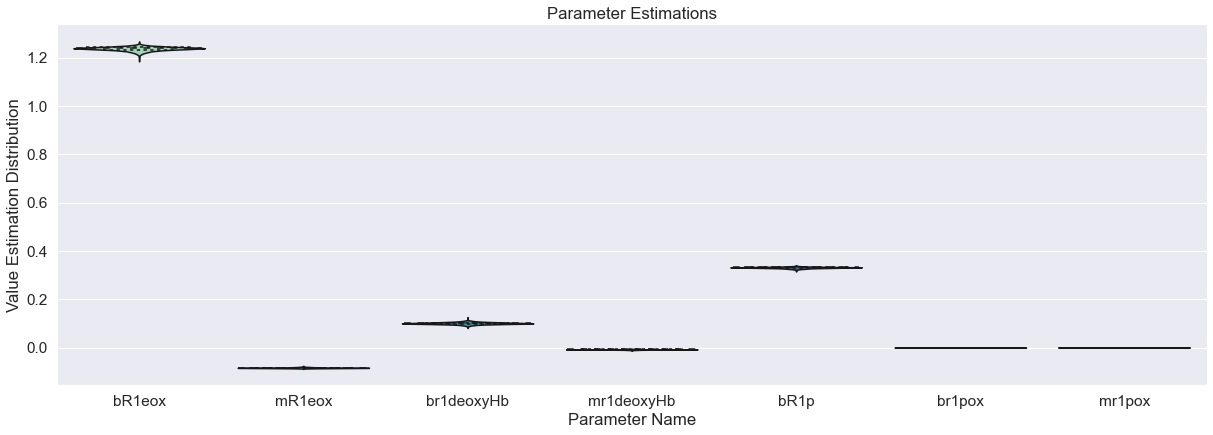

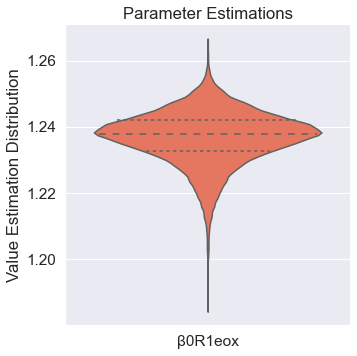

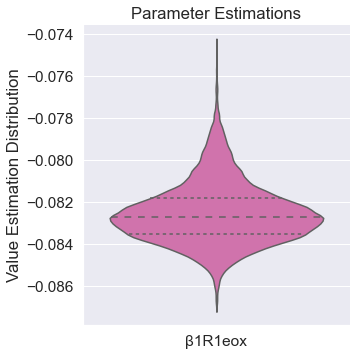

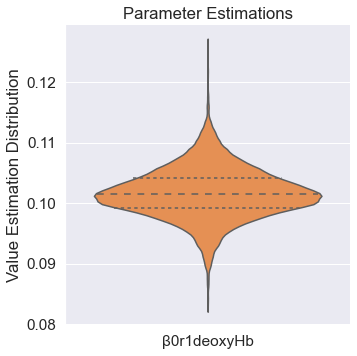

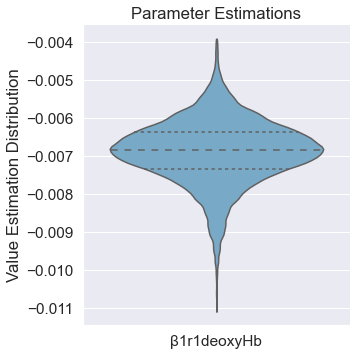

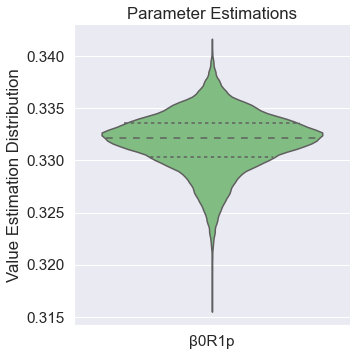

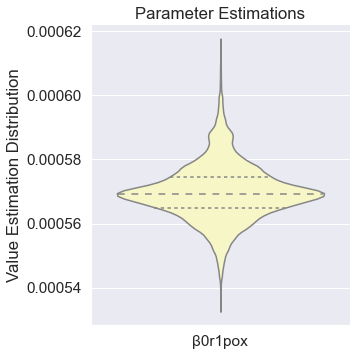

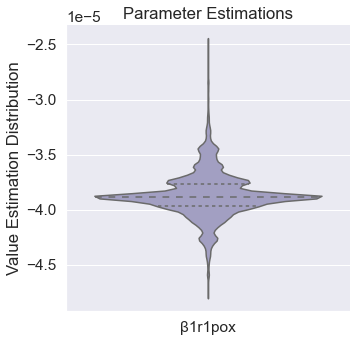

In [13]:
all_variables_o=np.array([list_of_bR1eox,list_of_mR1eox,list_of_br1deoxyHb, list_of_mr1deoxyHb, list_of_bR1p,list_of_br1pox_r1,list_of_mr1pox_r1])
all_variables=all_variables_o.T
np.shape(all_variables)
all_variables_df = pd.DataFrame(all_variables, columns = ['bR1eox','mR1eox','br1deoxyHb', 'mr1deoxyHb', 'bR1p','br1pox','mr1pox'])
sns.set(font_scale=1.4)
g = sns.catplot(data=all_variables_df,kind='violin',cut=0,scale='width',palette='mako_r',inner="quartile",bw=0.1);
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 6)
plt.ylabel('Value Estimation Distribution')
plt.xlabel('Parameter Name')
plt.title('Parameter Estimations')


all_variables_o=np.array([list_of_bR1eox])
all_variables=all_variables_o.T
np.shape(all_variables)
all_variables_df = pd.DataFrame(all_variables, columns = ['β0R1eox'])
sns.set(font_scale=1.4)
g = sns.catplot(data=all_variables_df,kind='violin',cut=0,scale='width',palette='Reds',inner="quartile",bw=0.1);
fig = matplotlib.pyplot.gcf()
plt.ylabel('Value Estimation Distribution')
plt.title('Parameter Estimations')


all_variables_o=np.array([list_of_mR1eox])
all_variables=all_variables_o.T
np.shape(all_variables)
all_variables_df = pd.DataFrame(all_variables, columns = ['β1R1eox'])
sns.set(font_scale=1.4)
g = sns.catplot(data=all_variables_df,kind='violin',cut=0,scale='width',palette='PuRd',inner="quartile",bw=0.1);
fig = matplotlib.pyplot.gcf()
plt.ylabel('Value Estimation Distribution')
plt.title('Parameter Estimations')


all_variables_o=np.array([list_of_br1deoxyHb])
all_variables=all_variables_o.T
np.shape(all_variables)
all_variables_df = pd.DataFrame(all_variables, columns = ['β0r1deoxyHb'])
sns.set(font_scale=1.4)
g = sns.catplot(data=all_variables_df,kind='violin',cut=0,scale='width',palette='YlOrRd',inner="quartile",bw=0.1);
fig = matplotlib.pyplot.gcf()
plt.ylabel('Value Estimation Distribution')
plt.title('Parameter Estimations')


all_variables_o=np.array([list_of_mr1deoxyHb])
all_variables=all_variables_o.T
np.shape(all_variables)
all_variables_df = pd.DataFrame(all_variables, columns = ['β1r1deoxyHb'])
sns.set(font_scale=1.4)
g = sns.catplot(data=all_variables_df,kind='violin',cut=0,scale='width',palette='Blues',inner="quartile",bw=0.1);
fig = matplotlib.pyplot.gcf()
plt.ylabel('Value Estimation Distribution')
plt.title('Parameter Estimations')


all_variables_o=np.array([list_of_bR1p])
all_variables=all_variables_o.T
np.shape(all_variables)
all_variables_df = pd.DataFrame(all_variables, columns = ['β0R1p'])
sns.set(font_scale=1.4)
g = sns.catplot(data=all_variables_df,kind='violin',cut=0,scale='width',palette='YlGn',inner="quartile",bw=0.1);
fig = matplotlib.pyplot.gcf()
plt.ylabel('Value Estimation Distribution')
plt.title('Parameter Estimations')


all_variables_o=np.array([list_of_br1pox_r1])
all_variables=all_variables_o.T
np.shape(all_variables)
all_variables_df = pd.DataFrame(all_variables, columns = ['β0r1pox'])
sns.set(font_scale=1.4)
g = sns.catplot(data=all_variables_df,kind='violin',cut=0,scale='width',palette='RdYlBu_r',inner="quartile",bw=0.1);
fig = matplotlib.pyplot.gcf()
plt.ylabel('Value Estimation Distribution')
plt.title('Parameter Estimations')


all_variables_o=np.array([list_of_mr1pox_r1])
all_variables=all_variables_o.T
np.shape(all_variables)
all_variables_df = pd.DataFrame(all_variables, columns = ['β1r1pox'])
sns.set(font_scale=1.4)
g = sns.catplot(data=all_variables_df,kind='violin',cut=0,scale='width',palette='Purples',inner="quartile",bw=0.1);
fig = matplotlib.pyplot.gcf()
plt.ylabel('Value Estimation Distribution')
plt.title('Parameter Estimations')


## Calculating the mean parameter values and confidence intervals
Do not move onto this step if your distributions are skewed (see previous step)

In [16]:
bR1eox_mean= np.mean(list_of_bR1eox)
mR1eox_mean=np.mean(list_of_mR1eox)
mr1deoxyHb_mean=np.mean(list_of_mr1deoxyHb)
br1deoxyHb_mean=np.mean(list_of_br1deoxyHb)
bR1p_mean=np.mean(list_of_bR1p)
mR1p_mean=np.mean(list_of_mR1p)
br1pox_mean=np.mean(list_of_br1pox_r1)
mr1pox_mean=np.mean(list_of_mr1pox_r1)


bR1eox_std= np.std(list_of_bR1eox)
mR1eox_std=np.std(list_of_mR1eox)
mr1deoxyHb_std=np.std(list_of_mr1deoxyHb)
br1deoxyHb_std=np.std(list_of_br1deoxyHb)
bR1p_std=np.std(list_of_bR1p)
mR1p_std=np.std(list_of_mR1p)
br1pox_std=np.std(list_of_br1pox_r1)
mr1pox_std=np.std(list_of_mr1pox_r1)


lowerCI_bR1eox = bR1eox_mean - 1.96*bR1eox_std
upperCI_bR1eox = bR1eox_mean + 1.96*bR1eox_std

lowerCI_mR1eox = mR1eox_mean - 1.96*mR1eox_std
upperCI_mR1eox = mR1eox_mean + 1.96*mR1eox_std

lowerCI_br1deoxyHb = br1deoxyHb_mean - 1.96*br1deoxyHb_std
upperCI_br1deoxyHb = br1deoxyHb_mean + 1.96*br1deoxyHb_std

lowerCI_mr1deoxyHb = mr1deoxyHb_mean - 1.96*mr1deoxyHb_std
upperCI_mr1deoxyHb = mr1deoxyHb_mean + 1.96*mr1deoxyHb_std

lowerCI_bR1p = bR1p_mean - 1.96*bR1p_std
upperCI_bR1p = bR1p_mean + 1.96*bR1p_std

lowerCI_br1pox = br1pox_mean - 1.96*br1pox_std
upperCI_br1pox = br1pox_mean + 1.96*br1pox_std

lowerCI_mr1pox = mr1pox_mean - 1.96*mr1pox_std
upperCI_mr1pox = mr1pox_mean + 1.96*mr1pox_std



print('bR1eox mean =',bR1eox_mean)
print('bR1eox std =',bR1eox_std)
print("lowerCI_bR1eox", lowerCI_bR1eox)
print("upperCI_bR1eox", upperCI_bR1eox )
print('\n')

print('mR1eox mean =',mR1eox_mean)
print('mR1eox std=',mR1eox_std)
print("lowerCI_mR1eox",lowerCI_mR1eox)
print("upperCI_mR1eox",upperCI_mR1eox)
print('\n')

print('br1deoxyHb mean =',br1deoxyHb_mean)
print('br1deoxyHb std=',br1deoxyHb_std)
print("lowerCI_br1deoxyHb", lowerCI_br1deoxyHb)
print("upperCI_br1deoxyHb", upperCI_br1deoxyHb )
print('\n')

print('mr1deoxyHb mean =',mr1deoxyHb_mean)
print('mr1deoxyHb std=',mr1deoxyHb_std)
print("lowerCI_mr1deoxyHb", lowerCI_mr1deoxyHb)
print("upperCI_mr1deoxyHb", upperCI_mr1deoxyHb)
print('\n')

print('bR1p mean =',bR1p_mean)
print('bR1p std=',bR1p_std)
print("lowerCI_bR1p", lowerCI_bR1p)
print("upperCI_bR1p ", upperCI_bR1p)
print('\n')

print('br1poxmean =',br1pox_mean)
print("lowerCI_br1pox",lowerCI_br1pox )
print("upperCI_br1pox ",upperCI_br1pox )
print('br1poxstd =',br1pox_std)
print('\n')

print('mr1poxmean =',mr1pox_mean)
print('mr1poxstd =',mr1pox_std)
print("lowerCI_mr1pox",lowerCI_mr1pox)
print("upperCI_mr1pox",upperCI_mr1pox)
print('\n')

bR1eox mean = 1.2368389424754502
bR1eox std = 0.00806953191459871
lowerCI_bR1eox 1.2210226599228367
upperCI_bR1eox 1.2526552250280638


mR1eox mean = -0.08250880494193057
mR1eox std= 0.0014686109771042516
lowerCI_mR1eox -0.0853872824570549
upperCI_mR1eox -0.07963032742680623


br1deoxyHb mean = 0.10168240043885987
br1deoxyHb std= 0.0041757527183151205
lowerCI_br1deoxyHb 0.09349792511096224
upperCI_br1deoxyHb 0.10986687576675751


mr1deoxyHb mean = -0.0068777467145386606
mr1deoxyHb std= 0.0008420749042154877
lowerCI_mr1deoxyHb -0.008528213526801016
upperCI_mr1deoxyHb -0.0052272799022763045


bR1p mean = 0.3318238222705497
bR1p std= 0.002764561917327004
lowerCI_bR1p 0.32640528091258875
upperCI_bR1p  0.3372423636285106


br1poxmean = 0.0005699268467233503
lowerCI_br1pox 0.0005523912911277796
upperCI_br1pox  0.000587462402318921
br1poxstd = 8.946712038556452e-06


mr1poxmean = -3.8664384457890905e-05
mr1poxstd = 2.066265865111249e-06
lowerCI_mr1pox -4.2714265553508956e-05
upperCI_mr1pox -3

## Examine the behaviour of the model
Plots with simulated data to illustrate the behaviour of Equation 10 (with parameters fit from all data). (A) PO2 vs R1b and T1b and (B) SO2 vs R1b and T1b for a range of haematocrit values (0.3-0.57) at 3T. (C) PO2 vs R1b and T1b at a range of field strengths (1.5-7T) with Hct=0.42. (D) Haematocrit vs R1b and T1b for a range of SO2 values (0-90%) at 3T. 

### Normoxic Conditions

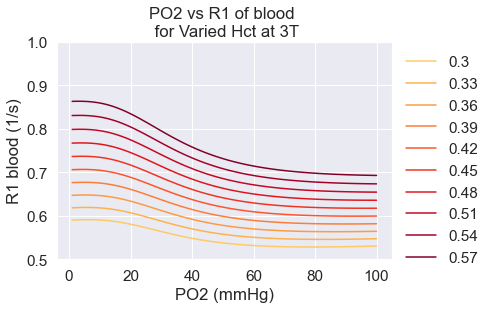

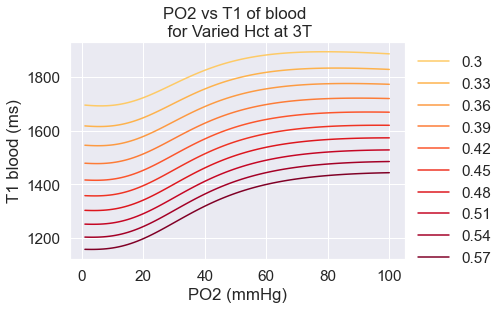

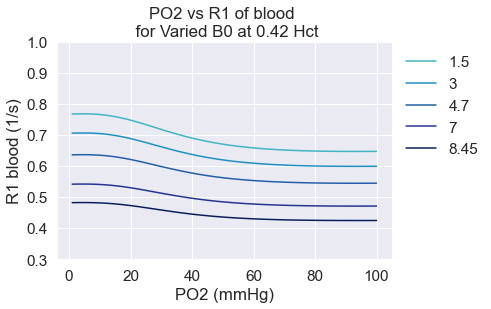

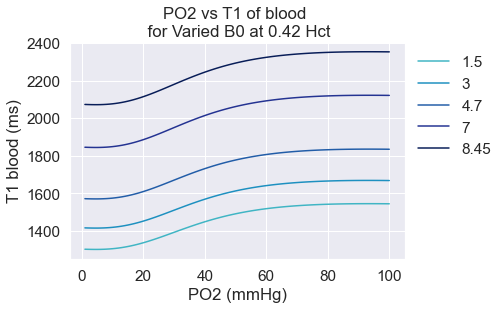

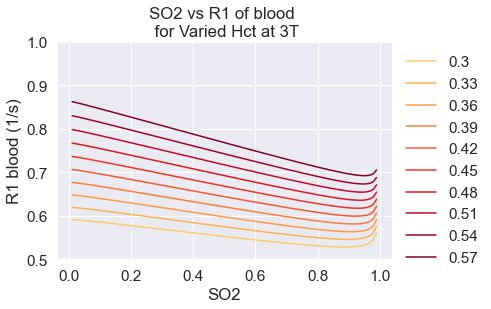

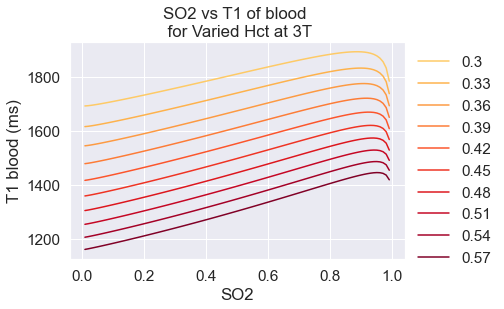

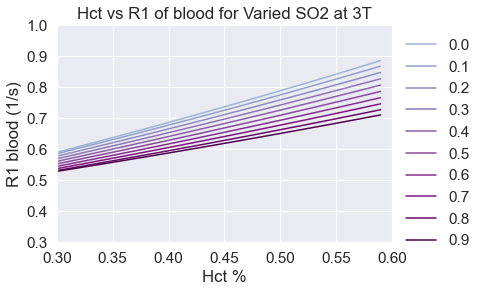

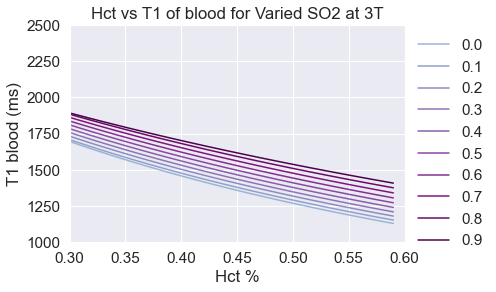

In [78]:
B0=3 # Tesla
 # from 0-1
Hb=5.15 # mmol Hb tetramer/L plasma
#print(fwatere)
n=2.7
P50=37

po2_xaxis=np.linspace(1,100,100)
po2=po2_xaxis

fig1 = plt.figure()
ax1 = fig1.add_subplot(111) 
for x in range(30,60,3):
    Hct=x/100
    fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
    R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+((br1pox_mean+(mr1pox_mean*B0))*po2))
    plt.plot(po2_xaxis,R1_blood,label=str(Hct))
    plt.title('PO2 vs R1 of blood \n for Varied Hct at 3T')
    plt.xlabel('PO2 (mmHg)')
    plt.ylabel('R1 blood (1/s)')
    plt.ylim(0.5,1)
colormap = plt.cm.YlOrRd #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.3, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.legend(bbox_to_anchor=(1, 1))
    

fig1 = plt.figure()
ax1 = fig1.add_subplot(111) 
for x in range(30,60,3):
    Hct=x/100
    fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
    R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+((br1pox_mean+(mr1pox_mean*B0))*po2))
    T1_blood=(1/R1_blood)*1000
    plt.plot(po2_xaxis,T1_blood,label=str(Hct))
    plt.title('PO2 vs T1 of blood \n for Varied Hct at 3T')
    plt.xlabel('PO2 (mmHg)')
    plt.ylabel('T1 blood (ms)')
colormap = plt.cm.YlOrRd #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.3, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.legend(bbox_to_anchor=(1, 1))


#################################################################################

Hb=5.15 # mmol Hb tetramer/L plasma
Hct=0.42

po2_xaxis=np.linspace(1,100,100)
po2=po2_xaxis
 

fig1 = plt.figure()
ax1 = fig1.add_subplot(111) 
for x in [1.5,3,4.7,7,8.45]:
    B0=x
    fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
    R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+((br1pox_mean+(mr1pox_mean*B0))*po2))
    plt.plot(po2_xaxis,R1_blood,label=str(B0))
    plt.title('PO2 vs R1 of blood \n for Varied B0 at 0.42 Hct')
    plt.xlabel('PO2 (mmHg)')
    plt.ylim(0.3,1)
    plt.ylabel('R1 blood (1/s)')
colormap = plt.cm.YlGnBu #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.5,1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.legend(bbox_to_anchor=(1, 1))
    

fig1 = plt.figure()
ax1 = fig1.add_subplot(111) 
for x in [1.5,3,4.7,7,8.45]:
    B0=x
    fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
    R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+((br1pox_mean+(mr1pox_mean*B0))*po2))
    T1_blood=(1/R1_blood)*1000
    plt.plot(po2_xaxis,T1_blood,label=str(B0))
    plt.title('PO2 vs T1 of blood \n for Varied B0 at 0.42 Hct')
    plt.xlabel('PO2 (mmHg)')
    plt.ylabel('T1 blood (ms)')
colormap = plt.cm.YlGnBu #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.5,1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.legend(bbox_to_anchor=(1, 1))

#################################################################################


#################################################################################



B0=3 # Tesla
 # from 0-1
Hb=5.15 # mmol Hb tetramer/L plasma

fig1 = plt.figure()
ax1 = fig1.add_subplot(111) 
for x in range(30,60,3):
    Hct=x/100
    fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
    so2=(np.arange(1,100))/100
    po2=(-(so2*(P50**n))/(so2-1))**(1/n)
    R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+((br1pox_mean+(mr1pox_mean*B0))*po2))
    plt.plot(so2,R1_blood,label=str(Hct))
    plt.title('SO2 vs R1 of blood \n for Varied Hct at 3T')
    plt.xlabel('SO2')
    plt.ylabel('R1 blood (1/s)')
    plt.ylim(0.5,1)
colormap = plt.cm.YlOrRd #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.3, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.legend(bbox_to_anchor=(1, 1))
    

fig1 = plt.figure()
ax1 = fig1.add_subplot(111) 
for x in range(30,60,3):
    Hct=x/100
    fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
    so2=(np.arange(1,100))/100
    po2=(-(so2*(P50**n))/(so2-1))**(1/n)
    R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+((br1pox_mean+(mr1pox_mean*B0))*po2))
    T1_blood=(1/R1_blood)*1000
    plt.plot(so2,T1_blood,label=str(Hct))
    plt.title('SO2 vs T1 of blood \n for Varied Hct at 3T')
    plt.xlabel('SO2')
    plt.ylabel('T1 blood (ms)')
colormap = plt.cm.YlOrRd #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.3, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.legend(bbox_to_anchor=(1, 1))


#################################################################################


Hb=5.15 # mmol Hb tetramer/L plasma
#print(fwatere)
B0=3

Hct=(np.arange(1,60))/100
fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))

fig1 = plt.figure()
ax1 = fig1.add_subplot(111) 
for i in range(0,100,10):
    so2=i/100
    po2=(-(so2*(P50**n))/(so2-1))**(1/n)
    R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+((br1pox_mean+(mr1pox_mean*B0))*po2))
    plt.plot(Hct,R1_blood,label=str(so2))
    colormap = plt.cm.BuPu #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0.4, 1,len(ax1.lines))]
    for i,j in enumerate(ax1.lines):
        j.set_color(colors[i])
    plt.title('Hct vs R1 of blood for Varied SO2 at 3T')
    plt.xlabel('Hct %')
    plt.ylabel('R1 blood (1/s)')
    plt.xlim(0.3,0.6)
    plt.ylim(0.3,1)
    plt.legend(bbox_to_anchor=(1, 1))

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
for i in range(0,100,10):
    so2=i/100
    po2=(-(so2*(P50**n))/(so2-1))**(1/n)
    R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+((br1pox_mean+(mr1pox_mean*B0))*po2))
    T1_blood=(1/R1_blood)*1000
    plt.plot(Hct,T1_blood,label=str(so2))
    colormap = plt.cm.BuPu #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0.4, 1,len(ax2.lines))]
    for i,j in enumerate(ax2.lines):
        j.set_color(colors[i])
    plt.title('Hct vs T1 of blood for Varied SO2 at 3T')
    plt.xlabel('Hct %')
    plt.ylabel('T1 blood (ms)')
    plt.xlim(0.3,0.6)
    plt.ylim(1000,2500)
    plt.legend(bbox_to_anchor=(1, 1))

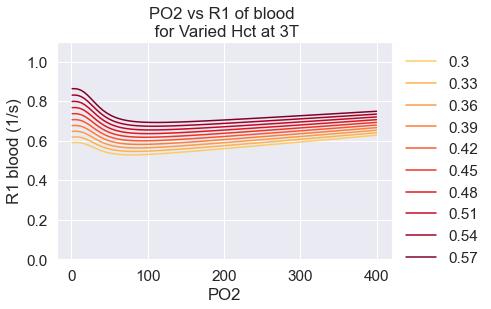

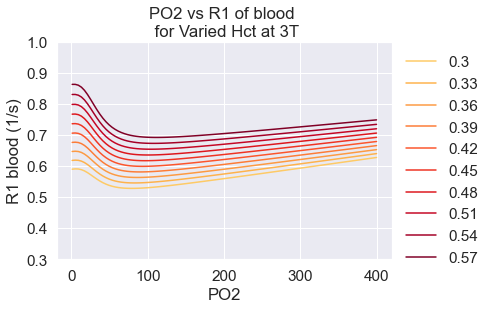

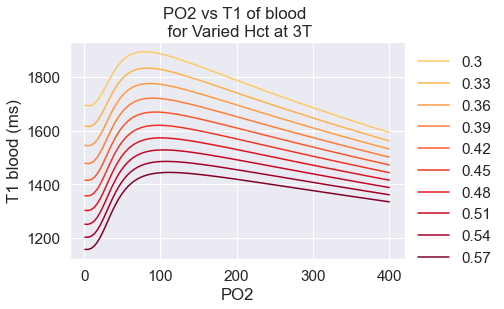

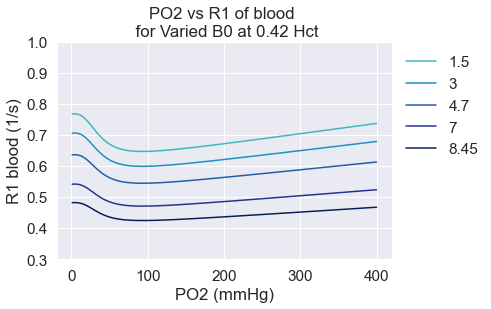

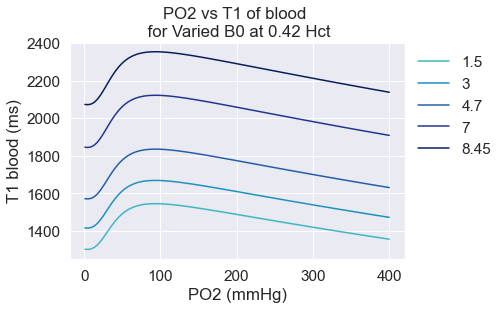

In [80]:
sns.set(font_scale=1.4)
B0=3 # Tesla
 # from 0-1
Hb=5.15 # mmol Hb tetramer/L plasma
#print(fwatere)
n=2.7
P50=37

po2_xaxis=np.linspace(1,400,100)
po2=po2_xaxis

fig1 = plt.figure()
ax1 = fig1.add_subplot(111) 
for x in range(30,60,3):
    Hct=x/100
    fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
    R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+((br1pox_mean+(mr1pox_mean*B0))*po2))
    plt.plot(po2_xaxis,R1_blood,label=str(Hct))
    plt.title('PO2 vs R1 of blood \n for Varied Hct at 3T')
    plt.xlabel('PO2')
    plt.ylabel('R1 blood (1/s)')
    plt.ylim(0,1.1)
colormap = plt.cm.YlOrRd #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.3, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.legend(bbox_to_anchor=(1, 1))


po2_xaxis=np.linspace(1,400,100)
po2=po2_xaxis

fig1 = plt.figure()
ax1 = fig1.add_subplot(111) 
for x in range(30,60,3):
    Hct=x/100
    fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
    R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+((br1pox_mean+(mr1pox_mean*B0))*po2))
    plt.plot(po2_xaxis,R1_blood,label=str(Hct))
    plt.title('PO2 vs R1 of blood \n for Varied Hct at 3T')
    plt.xlabel('PO2')
    plt.ylabel('R1 blood (1/s)')
    plt.ylim(0.3,1)
colormap = plt.cm.YlOrRd #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.3, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.legend(bbox_to_anchor=(1, 1))


    
    

fig1 = plt.figure()
ax1 = fig1.add_subplot(111) 
for x in range(30,60,3):
    Hct=x/100
    fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
    R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+((br1pox_mean+(mr1pox_mean*B0))*po2))
    T1_blood=(1/R1_blood)*1000
    plt.plot(po2_xaxis,T1_blood,label=str(Hct))
    plt.title('PO2 vs T1 of blood \n for Varied Hct at 3T')
    plt.xlabel('PO2')
    plt.ylabel('T1 blood (ms)')
colormap = plt.cm.YlOrRd #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.3, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.legend(bbox_to_anchor=(1, 1))




Hb=5.15 # mmol Hb tetramer/L plasma
Hct=0.42

po2_xaxis=np.linspace(1,400,100)
po2=po2_xaxis
 

fig1 = plt.figure()
ax1 = fig1.add_subplot(111) 
for x in [1.5,3,4.7,7,8.45]:
    B0=x
    fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
    R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+((br1pox_mean+(mr1pox_mean*B0))*po2))
    plt.plot(po2_xaxis,R1_blood,label=str(B0))
    plt.title('PO2 vs R1 of blood \n for Varied B0 at 0.42 Hct')
    plt.xlabel('PO2 (mmHg)')
    plt.ylim(0.3,1)
    plt.ylabel('R1 blood (1/s)')
colormap = plt.cm.YlGnBu #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.5,1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.legend(bbox_to_anchor=(1, 1))
    

fig1 = plt.figure()
ax1 = fig1.add_subplot(111) 
for x in [1.5,3,4.7,7,8.45]:
    B0=x
    fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
    R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+((br1pox_mean+(mr1pox_mean*B0))*po2))
    T1_blood=(1/R1_blood)*1000
    plt.plot(po2_xaxis,T1_blood,label=str(B0))
    plt.title('PO2 vs T1 of blood \n for Varied B0 at 0.42 Hct')
    plt.xlabel('PO2 (mmHg)')
    plt.ylabel('T1 blood (ms)')
colormap = plt.cm.YlGnBu #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.5,1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.legend(bbox_to_anchor=(1, 1))

## Compare new model against Hales 2016 model
Calculates the R2, MSE, and AIC score for both new model and Hales model on a subset of the data that is under non-hyperoxic conditions only.

In [93]:
r1data_normalonly = pd.read_csv('R1blood_data_table_normalonly.csv')
r1data_normalonly


bR1eox_EB=bR1eox_mean
mR1eox_EB=mR1eox_mean
br1deoxyHb_EB=br1deoxyHb_mean
mr1deoxyHb_EB=mr1deoxyHb_mean
bR1p_EB=bR1p_mean
mr1pox_EB=mr1pox_mean
br1pox_EB=br1pox_mean

bR1eox_Hales=1.10
mR1eox_Hales=-0.058
br1deoxyHb_Hales=0.033
bR1p_Hales=0.49
mR1p_Hales=-0.023

B0_test=r1data_normalonly.B0
y_test=r1data_normalonly.R1
fw_test=r1data_normalonly.fwatere
po2_test=r1data_normalonly.po2
so2_test=r1data_normalonly.so2
Hct_test=r1data_normalonly.Hct
P50_test=r1data_normalonly.P50

n=2.7
Hb=5.15


y_guess_EB=fw_test*((bR1eox_EB+(mR1eox_EB*B0_test)) + ((br1deoxyHb_EB+(mr1deoxyHb_EB*B0_test))*Hb*(1-((po2_test**n)/((po2_test**n)+(P50_test**n)))))) + (1-fw_test)*(bR1p_EB+((br1pox_EB+(mr1pox_EB*B0_test))*po2_test))
y_guess_Hales=fw_test*((bR1eox_Hales+(mR1eox_Hales*B0_test)) + (br1deoxyHb_Hales*Hb*(1-so2_test))) + (1-fw_test)*((bR1p_Hales+(mR1p_Hales*B0_test)))


y_guess_EB_reshape=np.reshape(y_guess_EB.to_numpy(),(-1, 1))
y_guess_Hales_reshape=np.reshape(y_guess_Hales.to_numpy(),(-1, 1))
y_test_reshape=np.reshape(y_test.to_numpy(),(-1, 1))

reg_Hales_v_true = LinearRegression().fit(y_test_reshape, y_guess_Hales_reshape)
reg_EB_v_true = LinearRegression().fit(y_test_reshape, y_guess_EB_reshape)
reg_Hales_v_EB = LinearRegression().fit(y_guess_Hales_reshape, y_guess_EB_reshape)


print('Hales vs True R2=',reg_Hales_v_true.score(y_test_reshape, y_guess_Hales_reshape))
print('New Model vs True R2=',reg_EB_v_true.score(y_test_reshape, y_guess_EB_reshape))
print('\n')

meanSE_Hales=mean_squared_error(y_test_reshape, y_guess_Hales_reshape)
meanSE_EB=mean_squared_error(y_test_reshape, y_guess_EB_reshape)
print("Hales vs True MSE=", meanSE_Hales)
print("New Model vs True MSE=", meanSE_EB)
print('\n')

AICSCORE_EB=aic.aic(y_test, y_guess_EB, 9)
AICSCORE_Hales=aic.aic(y_test, y_guess_Hales, 7)
print('AIC Hales',AICSCORE_Hales)
print('AIC New Model',AICSCORE_EB)
print('\n')

print('New model vs Hales', reg_Hales_v_EB.score(y_guess_EB_reshape, y_guess_Hales_reshape))


Hales vs True R2= 0.9226068020556532
New Model vs True R2= 0.9269989853190014


Hales vs True MSE= 0.0010556974854409422
New Model vs True MSE= 0.0009607668796669945


AIC Hales -547.9913957624678
AIC New Model -551.7178582718816


New model vs Hales 0.956884605760144


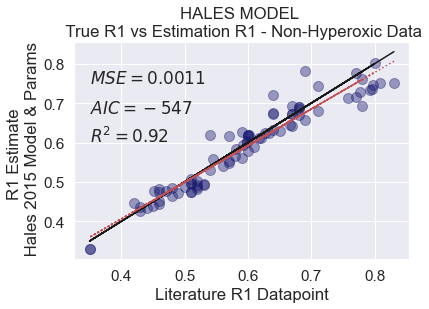

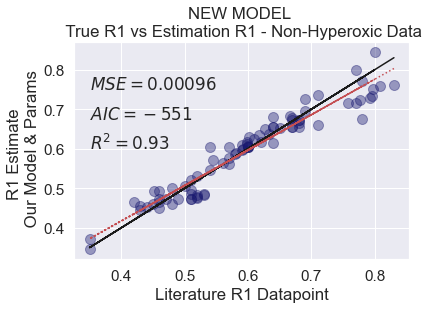

In [83]:
sns.set(font_scale=1.4)
plt.scatter(y_test, y_guess_Hales,s=100,alpha=0.4,color='midnightblue')
plt.plot(y_test, y_test,'k')
plt.plot(y_test,np.squeeze(reg_Hales_v_true.predict(y_test_reshape)),'r',linestyle='dotted')
plt.xlabel('Literature R1 Datapoint')
plt.ylabel('R1 Estimate \n Hales 2015 Model & Params')
plt.title('HALES MODEL \n True R1 vs Estimation R1 - Non-Hyperoxic Data')
plt.text(0.35,0.675, '$AIC=-547$')
plt.text(0.35,0.6, '$R^2=0.92$')
plt.text(0.35,0.75, '$MSE=0.0011$')
plt.show()


plt.scatter(y_test, y_guess_EB,s=100,alpha=0.4,color='midnightblue')
plt.plot(y_test, y_test,'k')
plt.plot(y_test,np.squeeze(reg_EB_v_true.predict(y_test_reshape)),'r',linestyle='dotted')
plt.xlabel('Literature R1 Datapoint')
plt.ylabel('R1 Estimate \n Our Model & Params')
plt.title('NEW MODEL \n True R1 vs Estimation R1 - Non-Hyperoxic Data')
plt.text(0.35,0.675, '$AIC=-551$')
plt.text(0.35,0.6, '$R^2=0.93$')
plt.text(0.35,0.75, '$MSE=0.00096$')
plt.show()


In [81]:
len(y_guess_EB)

82

## Create True vs Predicted plot of final new model on all data
The modelled vs measured R1b values, plotted against the line of equality (solid black line) and a linear regression (red dotted line)
### Main plots

0.001329446038838091
Estimate vs True R2= 0.9303125650302652


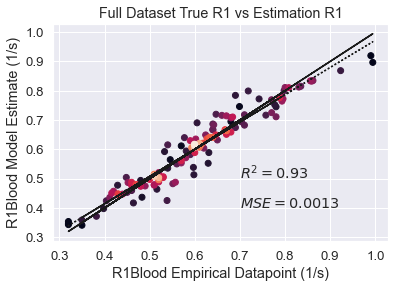

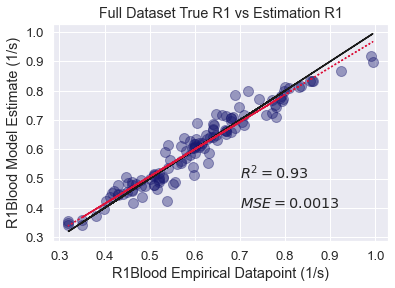

126


In [84]:
r1data_all = pd.read_csv('R1blood_data_table.csv')
r1data_all

bR1eox_EB=bR1eox_mean
mR1eox_EB=mR1eox_mean
br1deoxyHb_EB=br1deoxyHb_mean
mr1deoxyHb_EB=mr1deoxyHb_mean
bR1p_EB=bR1p_mean
mR1p_EB=mR1p_mean
mr1pox_EB=mr1pox_mean
br1pox_EB=br1pox_mean


n=2.7
Hb=5.15

B0_all=r1data_all.B0
y_all=r1data_all.R1
fw_all=r1data_all.fwatere
po2_all=r1data_all.po2
so2_all=r1data_all.so2
Hct_all=r1data_all.Hct
P50_all=r1data_all.P50
refnumber=r1data_all.Refnumber

y_pred=fw_all*((bR1eox_EB+(mR1eox_EB*B0_all)) + ((br1deoxyHb_EB+(mr1deoxyHb_EB*B0_all))*Hb*(1-((po2_all**n)/((po2_all**n)+(P50_all**n)))))) + (1-fw_all)*(bR1p_EB+((br1pox_EB+(mr1pox_EB*B0_all))*po2_all))
y_true=y_all

meanSE=mean_squared_error(y_true, y_pred)
print(meanSE)


y_pred=np.asarray(y_pred)
y_true=np.asarray(y_true)

y_pred_reshape=y_pred.reshape(-1, 1)
y_true_reshape=y_true.reshape(-1, 1)

y_error_final=y_pred-y_true
y_error_final_mean=np.mean(y_error_final)
y_error_final_std=np.std(y_error_final)

reg_v_true_final = LinearRegression().fit(y_true_reshape,y_pred_reshape)


sns.set(font_scale=1.2)
density_scatter(y_true,y_pred,bins = [30,30])
print('Estimate vs True R2=',reg_v_true_final.score(y_true_reshape,y_pred_reshape))
plt.plot(y_true,y_true,'k')
plt.plot(y_true_reshape,np.squeeze(reg_v_true_final.predict(y_true_reshape)),'k',linestyle='dotted')
plt.text(0.7,0.5, '$R^2=0.93$')
plt.text(0.7,0.4, '$MSE=0.0013$')
plt.xlabel('R1Blood Empirical Datapoint (1/s)')
plt.ylabel('R1Blood Model Estimate (1/s)')
plt.title('Full Dataset True R1 vs Estimation R1')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(y_true,y_pred,s=100,alpha=0.4,color='midnightblue')
plt.plot(y_true,y_true,'k')
plt.plot(y_true,np.squeeze(reg_v_true_final.predict(y_true_reshape)),'k',linestyle='dotted',color='crimson')
plt.text(0.7,0.5, '$R^2=0.93$')
plt.text(0.7,0.4, '$MSE=0.0013$')
plt.xlabel('R1Blood Empirical Datapoint (1/s)')
plt.ylabel('R1Blood Model Estimate (1/s)')
plt.title('Full Dataset True R1 vs Estimation R1')
plt.show()

print(len(y_pred))

### Bland-Altman plots
(B) A Bland-Altman plot showing the difference between the modelled and measured values of R1b. The horizontal long-dashed lines show the mean value of ΔR1b, and the horizontal dotted lines show the limits of agreement (long dashes, calculated by mean(ΔR1b) ± (1.96xSD(ΔR1b)). Bland-Altman plots for the error in modelled R1blood against (C) SO2, (D) haematocrit, (E) B0, and (F) PO2 levels are also shown to examine bias in the model.

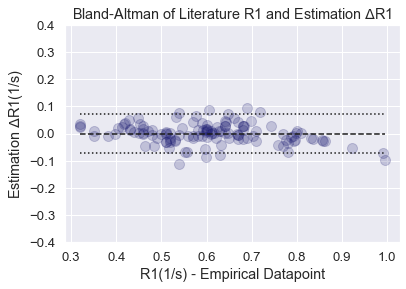

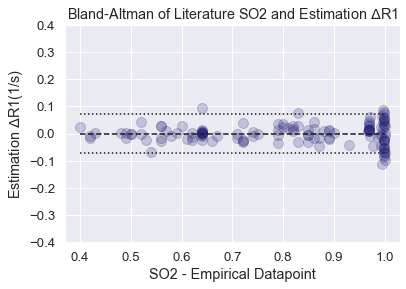

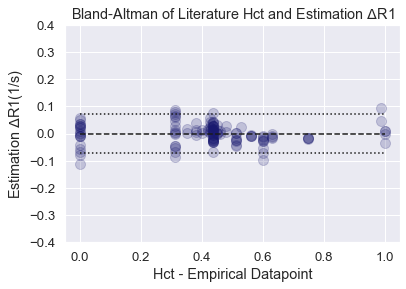

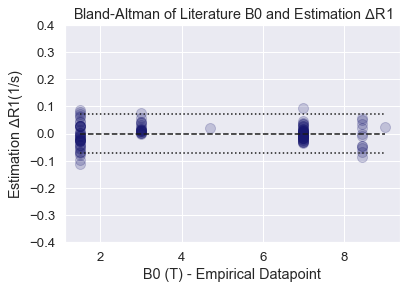

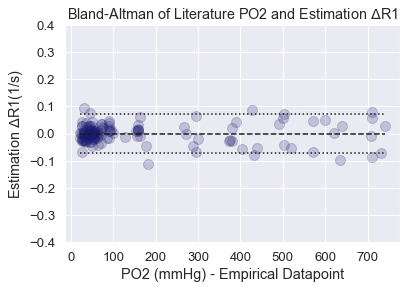

In [32]:
crude_lower_limit = y_error_final_mean-1.96*y_error_final_std
crude_upper_limit = y_error_final_mean+ 1.96*y_error_final_std

sns.set(font_scale=1.2)

plt.scatter(y_true,y_error_final,s=100,alpha=0.2,color='midnightblue')
plt.hlines(y_error_final_mean,np.min(y_true),np.max(y_true),linestyle='dashed')
plt.hlines(crude_lower_limit,np.min(y_true),np.max(y_true),linestyle='dotted')
plt.hlines(crude_upper_limit,np.min(y_true),np.max(y_true),linestyle='dotted')
plt.ylim(-0.4,0.4)
plt.xlabel('R1(1/s) - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$R1(1/s)')
plt.title('Bland-Altman of Literature R1 and Estimation $\Delta$R1')
plt.show()

plt.scatter(so2_all,y_error_final,s=100,alpha=0.2,color='midnightblue')
plt.hlines(y_error_final_mean,np.min(so2_all),np.max(so2_all),linestyle='dashed')
plt.hlines(crude_lower_limit,np.min(so2_all),np.max(so2_all),linestyle='dotted')
plt.hlines(crude_upper_limit,np.min(so2_all),np.max(so2_all),linestyle='dotted')
plt.ylim(-0.4,0.4)
plt.xlabel('SO2 - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$R1(1/s)')
plt.title('Bland-Altman of Literature SO2 and Estimation $\Delta$R1')
plt.show()

plt.scatter(Hct_all,y_error_final,s=100,alpha=0.2,color='midnightblue')
plt.hlines(y_error_final_mean,np.min(Hct_all),np.max(Hct_all),linestyle='dashed')
plt.hlines(crude_lower_limit,np.min(Hct_all),np.max(Hct_all),linestyle='dotted')
plt.hlines(crude_upper_limit,np.min(Hct_all),np.max(Hct_all),linestyle='dotted')
plt.ylim(-0.4,0.4)
plt.xlabel('Hct - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$R1(1/s)')
plt.title('Bland-Altman of Literature Hct and Estimation $\Delta$R1')
plt.show()

plt.scatter(B0_all,y_error_final,s=100,alpha=0.2,color='midnightblue')
plt.hlines(y_error_final_mean,np.min(B0_all),np.max(B0_all),linestyle='dashed')
plt.hlines(crude_lower_limit,np.min(B0_all),np.max(B0_all),linestyle='dotted')
plt.hlines(crude_upper_limit,np.min(B0_all),np.max(B0_all),linestyle='dotted')
plt.ylim(-0.4,0.4)
plt.xlabel('B0 (T) - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$R1(1/s)')
plt.title('Bland-Altman of Literature B0 and Estimation $\Delta$R1')
plt.show()

plt.scatter(po2_all,y_error_final,s=100,alpha=0.2,color='midnightblue')
plt.hlines(y_error_final_mean,np.min(po2_all),np.max(po2_all),linestyle='dashed')
plt.hlines(crude_lower_limit,np.min(po2_all),np.max(po2_all),linestyle='dotted')
plt.hlines(crude_upper_limit,np.min(po2_all),np.max(po2_all),linestyle='dotted')
plt.ylim(-0.4,0.4)
plt.xlabel('PO2 (mmHg) - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$R1(1/s)')
plt.title('Bland-Altman of Literature PO2 and Estimation $\Delta$R1')
plt.show()

## Viewing the RBC and Plasma Compartments

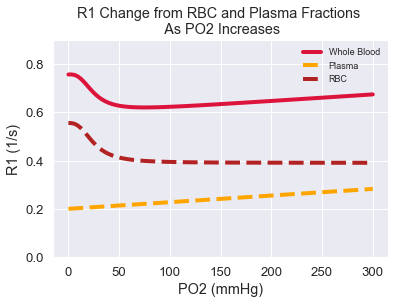

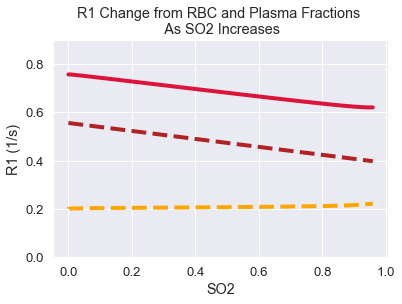

In [48]:

sns.set(font_scale=1.2)
B0=3 # Tesla
 # from 0-1
Hb=5.15 # mmol Hb tetramer/L plasma
#print(fwatere)
n=2.7
P50=25

Hct=0.47
po2_xaxis=np.linspace(0,300,100)
po2=po2_xaxis

fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+(br1pox_mean+(mr1pox_mean*B0))*po2)
R1_eryth=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n))))))
R1_plasma=(1-fw)*(bR1p_mean+(br1pox_mean+(mr1pox_mean*B0))*po2)
plt.plot(po2_xaxis,R1_blood,'crimson',linewidth=4,label='Whole Blood')
plt.plot(po2_xaxis,R1_plasma,'orange',linestyle='dashed',linewidth=4,label='Plasma')
plt.plot(po2_xaxis,R1_eryth,'firebrick',linestyle='dashed',linewidth=4,label='RBC')
plt.ylim(0,0.9)
plt.xlabel('PO2 (mmHg)')
plt.ylabel('R1 (1/s)')
plt.title('R1 Change from RBC and Plasma Fractions \n As PO2 Increases')
plt.legend(fontsize=9)
plt.show()

po2_xaxis=np.linspace(0,80,100)
po2=po2_xaxis

fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
so2=(po2**n)/((po2**n)+(P50**n))

R1_blood=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+(br1pox_mean+(mr1pox_mean*B0))*po2)
R1_eryth=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n))))))
R1_plasma=(1-fw)*(bR1p_mean+(br1pox_mean+(mr1pox_mean*B0))*po2)

plt.plot(so2,R1_blood,'crimson',linewidth=4,label='Whole Blood')
plt.plot(so2,R1_plasma,'orange',linestyle='dashed',linewidth=4,label='Plasma')
plt.plot(so2,R1_eryth,'firebrick',linestyle='dashed',linewidth=4,label='RBC')
plt.ylim(0,0.9)
plt.xlabel('SO2')
plt.ylabel('R1 (1/s)')
plt.title('R1 Change from RBC and Plasma Fractions \n As SO2 Increases')
plt.show()


## Venous vs. Arterial Blood

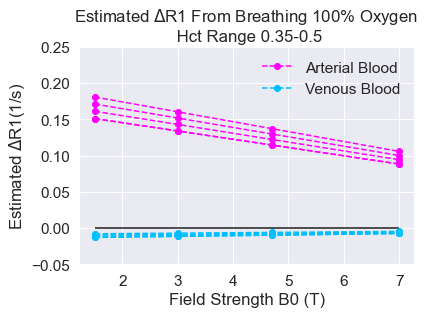

In [47]:
Hb=5.15 # mmol Hb tetramer/L plasma
sns.set(font_scale=1.4)
po2_xaxis=np.linspace(39,48,50)
po2_before=98
po2_after=600
list_R1delta_artery=np.zeros((10,4))
list_R1delta_venous=np.zeros((10,4))
B0_list_xaxis=[1.5,3,4.7,7]

P50=25
jcounter=0


fig1 = plt.figure()
ax1 = fig1.add_subplot(111) 
for j in range(35,50,4):
    i=0
    Hct=j/100
    for x in [1.5,3,4.7,7]:
        B0=x
        fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
        po2=po2_before
        R1_blood_before=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+(br1pox_mean+(mr1pox_mean*B0))*po2)
        po2=po2_after
        R1_blood_after=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+(br1pox_mean+(mr1pox_mean*B0))*po2)
        deltaR1=R1_blood_after-R1_blood_before
        list_R1delta_artery[jcounter,i]=deltaR1
        
        po2=39
        R1_blood_before=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+(br1pox_mean+(mr1pox_mean*B0))*po2)
        po2=48
        R1_blood_after=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+(br1pox_mean+(mr1pox_mean*B0))*po2)
        deltaR1=R1_blood_after-R1_blood_before
        list_R1delta_venous[jcounter,i]=deltaR1
        
        i=i+1
        
    plt.plot(B0_list_xaxis,list_R1delta_artery[jcounter],'o',linestyle='dashed',color='magenta')
    plt.plot(B0_list_xaxis,list_R1delta_venous[jcounter],'o',linestyle='dashed',color='deepskyblue')

    jcounter=jcounter+1
plt.plot(B0_list_xaxis,list_R1delta_artery[jcounter-1],'o',linestyle='dashed',color='magenta',label='Arterial Blood')
plt.plot(B0_list_xaxis,list_R1delta_venous[jcounter-1],'o',linestyle='dashed',color='deepskyblue',label='Venous Blood')
plt.hlines(0,np.min(B0_list_xaxis),np.max(B0_list_xaxis),'k')
plt.title('Estimated $\Delta$R1 From Breathing 100% Oxygen \n Hct Range 0.35-0.5')
plt.xlabel('Field Strength B0 (T)')
plt.ylabel('Estimated $\Delta$R1(1/s)')
plt.ylim(-0.05,0.25)
plt.legend()

## Venous Blood Figure

(-0.09, 0.15)

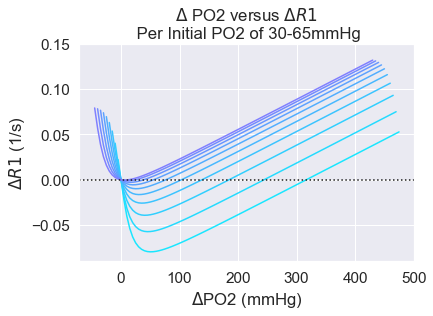

In [90]:
sns.set(font_scale=1.4)
Hct=0.42 # from 0-1
Hb=5.15 # mmol Hb tetramer/L plasma
#print(fwatere)
B0=1.5
P50=25

paO2_after_list=np.arange(20,500,5,dtype=float)
paO2_before_list=np.arange(20,70,5,dtype=float)# mmHg

delta_R1bloodtotal_list=np.zeros((len(paO2_before_list),len(paO2_after_list)))

deltapaO2_list=np.zeros((len(paO2_before_list),len(paO2_after_list)))


fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

for i in range(0,len(paO2_before_list)):
    for j in range(0,len(paO2_after_list)):
        #R1arterialbefore:
        paO2before=paO2_before_list[i] #mmHg
        po2=paO2before
        R1_blood_before=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+(br1pox_mean+(mr1pox_mean*B0))*po2)

        #R1arterialafter:
        paO2after=paO2_after_list[j] #mmHg
        po2=paO2after
        R1_blood_after=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*(bR1p_mean+(br1pox_mean+(mr1pox_mean*B0))*po2)

        deltapaO2=paO2after-paO2before
        
        deltaR1bloodtotal=R1_blood_after-R1_blood_before
        
        paO2before=paO2_before_list[i] #mmHg

        deltapaO2_list[i,j]=deltapaO2

        delta_R1bloodtotal_list[i,j]=deltaR1bloodtotal

    
for i in range(0,len(paO2_before_list)):
    plt.plot(deltapaO2_list[i],delta_R1bloodtotal_list[i],label=paO2_before_list[i])

colormap = plt.cm.cool #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.1, 0.5,len(ax2.lines))]
for i,j in enumerate(ax2.lines):
    j.set_color(colors[i])
    
plt.axhline(color='k',linestyle='dotted')

 
plt.title('$\Delta$ PO2 versus $\Delta R1$ \n Per Initial PO2 of 30-65mmHg')
plt.xlabel('$\Delta $PO2 (mmHg)')
plt.ylabel('$\Delta R1$ (1/s)')
sns.set(font_scale=0.9)
plt.ylim(-0.09,0.15)
#plt.legend()
#plt.legend(bbox_to_anchor=(1, 1))


## Arterial Blood Figure

(-0.09, 0.15)

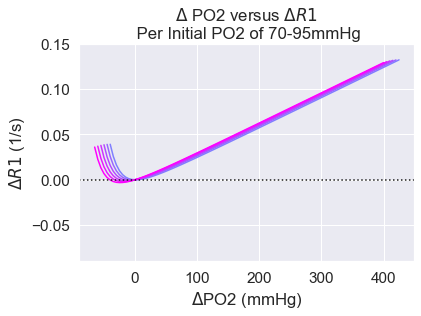

In [89]:
sns.set(font_scale=1.4)
Hct=0.42 # from 0-1
Hb=5.15 # mmol Hb tetramer/L plasma
#print(fwatere)
B0=1.5
P50=25

paO2_after_list=np.arange(30,500,5,dtype=float)
paO2_before_list=np.arange(70,100,5,dtype=float)# mmHg

delta_R1bloodtotal_list=np.zeros((len(paO2_before_list),len(paO2_after_list)))

deltapaO2_list=np.zeros((len(paO2_before_list),len(paO2_after_list)))


fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

for i in range(0,len(paO2_before_list)):
    for j in range(0,len(paO2_after_list)):
        #R1arterialbefore:
        paO2before=paO2_before_list[i] #mmHg
        po2=paO2before
        R1_blood_before=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*((bR1p_mean+(mR1p_mean*B0))+(br1pox_mean+(mr1pox_mean*B0))*po2)

        #R1arterialafter:
        paO2after=paO2_after_list[j] #mmHg
        po2=paO2after
        R1_blood_after=fw*((bR1eox_mean+(mR1eox_mean*B0))+((br1deoxyHb_mean+(mr1deoxyHb_mean*B0))*Hb*(1-((po2**n)/((po2**n)+(P50**n)))))) + (1-fw)*((bR1p_mean+(mR1p_mean*B0))+(br1pox_mean+(mr1pox_mean*B0))*po2)

        deltapaO2=paO2after-paO2before
        
        deltaR1bloodtotal=R1_blood_after-R1_blood_before
        
        paO2before=paO2_before_list[i] #mmHg

        deltapaO2_list[i,j]=deltapaO2

        delta_R1bloodtotal_list[i,j]=deltaR1bloodtotal

    
for i in range(0,len(paO2_before_list)):
    plt.plot(deltapaO2_list[i],delta_R1bloodtotal_list[i],label=paO2_before_list[i])

colormap = plt.cm.cool #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.5, 1,len(ax2.lines))]
for i,j in enumerate(ax2.lines):
    j.set_color(colors[i])
    
plt.axhline(color='k',linestyle='dotted')

 
plt.title('$\Delta$ PO2 versus $\Delta R1$ \n Per Initial PO2 of 70-95mmHg')
plt.xlabel('$\Delta $PO2 (mmHg)')
plt.ylabel('$\Delta R1$ (1/s)')
sns.set(font_scale=1)
plt.ylim(-0.09,0.15)
#plt.legend()
#plt.legend(bbox_to_anchor=(1, 1))